In [2]:
%pip install imblearn
%pip install pandas
%pip install shap
%pip install matplot
%pip install seaborn
%pip install altair

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement mlxtend.plotting (from versions: none)
ERROR: No matching distribution found for mlxtend.plotting
Note: you may need to restart the kernel to use updated packages.


## expand a labeled dataset to SMOTE

magnify the number of minority/exceptional cases within the sequence dataset, ideally targets the binary binned dataset.

[reference 1](<ver5-ordinal-binning-grid-searches/step 2-0, ranged clustering, with time.ipynb>)

different oversampling tools: Naive random oversampling, SMOTE, ADASYN, SMOTENC, locate the most effective, while optimizing the accuracy of a binary classifier. ~98 accuracy

a set of ensemble methods are tested then compiled into a voting classifier. ~90 accuracy

In [1]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE,SMOTENC, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
import pandas as pd 

from sklearn.metrics import balanced_accuracy_score
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier,RUSBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
import shap
import pandas as pd
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  VotingClassifier 
from sklearn.model_selection import cross_val_score


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
m2_pipeline = pd.read_csv("binary_binned_pipeline.csv")

In [11]:
m2_pipeline.columns #do this to identify the index of the categorical feature, for below setup

Index(['Unnamed: 0', 'precursor_buy_cap_pct_change',
       'precursor_ask_cap_pct_change', 'precursor_bid_vol_pct_change',
       'precursor_ask_vol_pct_change', 'sum_change', 'length',
       'surge_targets_met_pct', 'time', 'label'],
      dtype='object')

In [5]:
# keepable = ['precursor_buy_cap_pct_change', 
#             'precursor_ask_cap_pct_change',
#             'precursor_bid_vol_pct_change', 
#             'precursor_ask_vol_pct_change',
#             'sum_change','length','time']

# y = m2_pipeline['label'].values #per https://stackoverflow.com/a/73095562/12001832
# X = m2_pipeline[keepable].values
# # Performing the test/train split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# #normalize all numeric columns
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
    

In [6]:
# #set up toolsets as functions to build separate datasets, bin_Naive, bin_SMOTE, bin_ADASYN

# def build_naive():  #https://imbalanced-learn.org/stable/over_sampling.html#naive-random-over-sampling
#     ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
#     X_resampled, y_resampled = ros.fit_resample(X, y)
#     print("ROS",sorted(Counter(y_resampled).items()))
#     return X_resampled, y_resampled

# def build_smote(): #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#smote
#     X_resampled, y_resampled = SMOTE(random_state=42 ).fit_resample(X, y)
#     print("SMOTE",sorted(Counter(y_resampled).items()))
#     return X_resampled, y_resampled

# def build_adasyn(): #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html#adasyn
#     X_resampled, y_resampled = ADASYN(random_state=42,sampling_strategy='minority').fit_resample(X, y)
#     print("ADASYN",sorted(Counter(y_resampled).items()))
#     return X_resampled, y_resampled

# def build_borderline(): #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html#borderlinesmote
#     X_resampled, y_resampled = BorderlineSMOTE(random_state=42,sampling_strategy='minority').fit_resample(X, y)
#     print("BORDERLINE",sorted(Counter(y_resampled).items())) 
#     return X_resampled, y_resampled

# def build_smotenc(): #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#smotenc
#     smote_nc = SMOTENC( random_state=42,sampling_strategy='minority')
#     X_resampled, y_resampled = smote_nc.fit_resample(X, y)
#     print("SMOTENC",sorted(Counter(y_resampled).items()))
#     return X_resampled, y_resampled

# def build_svmsmote():
#     sm = SVMSMOTE(random_state=42)
#     X_res, y_res = sm.fit_resample(X, y)
#     print("SVMSMOTE",'Resampled dataset shape %s' % Counter(y_res))
#     return X_res, y_res

# def build_kmsmote(): #https://imbalanced-learn.org/stable/combine.html#combination-of-over-and-under-sampling
#     m = KMeansSMOTE( random_state=42,sampling_strategy='minority')
#     X_res, y_res = m.fit_resample(X, y)
#     # Find the number of new samples in the middle blob
#     n_res_in_middle = ((X_res[:, 0] > -5) & (X_res[:, 0] < 5)).sum()
#     print("KMSMOTE","Samples in the middle blob: %s" % n_res_in_middle)
#     return X_res, y_res

# def build_smoteenn():
#     smote_enn = SMOTEENN(random_state=42,sampling_strategy='minority')
#     X_resampled, y_resampled = smote_enn.fit_resample(X, y)
#     print("SMOTEENN",sorted(Counter(y_resampled).items()))
#     return X_resampled, y_resampled

# def build_smotetomek():
#     smote_tomek = SMOTETomek(random_state=42,sampling_strategy='minority')
#     X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
#     print("SMOTETOMEK",sorted(Counter(y_resampled).items()))
#     return X_resampled, y_resampled

### take optimal classifier parameters and technique

In [33]:
# def getBestClassifier(oversampler, dataset):   #'kmsmote', build_svmsmote(source)

keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length','time']

y = m2_pipeline['label'].values #per https://stackoverflow.com/a/73095562/12001832
X = m2_pipeline[keepable].values
    
X_resampled, y_resampled = ADASYN(random_state=42 ).fit_resample(X, y) #create synthetic classes

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()  #standardize all numerics
X_train_scaled = scaler.fit_transform(X_train)

classifiers = [  # Define the classifiers and their respective hyperparameters
    LogisticRegression(),
    BernoulliNB(),
    KNeighborsClassifier(),
]
params = {
    'LogisticRegression':{'C': [0.1, 1, 10], 'penalty':['l1','l2','elasticnet','None'], 'multi_class':['ovr','auto'],\
                            'random_state':[42]},
    'BernoulliNB':{'fit_prior':[True, False]},
    'KNeighborsClassifier':{'n_neighbors':[3,4,5,6,7,8], 'algorithm':['auto'], 'n_jobs':[1,2,3,4]}
}
comparative = []
# Perform the grid search
for clf in classifiers:
    name = clf.__class__.__name__
    if name in params:
        grid_search = GridSearchCV(clf, params[name], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        accuracy = grid_search.score(X_test, y_test)
        
        dict = {"classifier":name, "best_params":grid_search.best_params_, "accuracy":accuracy}
        comparative.append(dict)
# return(comparative)


90 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stefan/Desktop/GRUS/caret1/core/gh-code/grus-code/.conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stefan/Desktop/GRUS/caret1/core/gh-code/grus-code/.conda/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/stefan/Desktop/GRUS/caret1/core/gh-code/grus-code/.conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solv

Best parameters for LogisticRegression: {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}
Best parameters for BernoulliNB: {'fit_prior': True}
Best parameters for KNeighborsClassifier: {'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 3}


## trigger the search mechanism, per SMOTE method

loop through each oversampled dataset, then run the classifier search on that set, outlining each set, before hand

for each set, run the classifier search

In [34]:

# source = 'binary_binned_pipeline.csv'
# resultSet = []
# resultSet.append(getBestClassifier('naive', build_naive()))  #many rows
# resultSet.append(getBestClassifier('smote', build_smote()))
# resultSet.append(getBestClassifier('adasyn', build_adasyn()))
# resultSet.append(getBestClassifier('borderline', build_borderline()))
# # resultSet.append(getBestClassifier('smotenc', build_smotenc()))
# resultSet.append(getBestClassifier('svmsmote', build_svmsmote()))
# # resultSet.append(getBestClassifier('kmsmote', build_kmsmote()))
# resultSet.append(getBestClassifier('smoteenn', build_smoteenn()))
# resultSet.append(getBestClassifier('smotetomek', build_smotetomek()))

optimals = pd.DataFrame(comparative)

In [35]:
optimals

,classifier,best_params,accuracy
0,LogisticRegression,"{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2...",0.511821
1,BernoulliNB,{'fit_prior': True},0.500000
2,KNeighborsClassifier,"{'algorithm': 'auto', 'n_jobs': 1, 'n_neighbor...",0.511821


In [36]:
print_dict = lambda x: print(x)

# Apply the lambda function to each row of the data frame
optimals.applymap(print_dict)

LogisticRegression
BernoulliNB
KNeighborsClassifier
{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}
{'fit_prior': True}
{'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 3}
0.5118213660245184
0.5
0.5118213660245184


DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,classifier,best_params,accuracy
0,None,None,None
1,None,None,None
2,None,None,None


[pitfalls of oversampling](https://imbalanced-learn.org/stable/common_pitfalls.html#data-leakage)

## sampling based ensemble methods

score each, can you combine into a voter?

[validation curve model selection](https://imbalanced-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#plotting-validation-curves)

In [37]:
# balanced bagger

bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)
bbc.fit(X_train_scaled, y_train)
y_pred_bbc = bbc.predict(X_test)
balanced_accuracy_score(y_test, y_pred_bbc)

`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


0.5

In [38]:
#balanced tree estimator
brf = BalancedRandomForestClassifier(
    n_estimators=100, random_state=42, sampling_strategy="all", replacement=True
)
brf.fit(X_train_scaled, y_train)
y_pred_brf = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred_brf)

0.5

In [39]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=42)
rusboost.fit(X_train_scaled, y_train)
y_pred_rb = rusboost.predict(X_test)
balanced_accuracy_score(y_test, y_pred_rb)

0.5

In [40]:

vc = VotingClassifier(estimators=[('bbc',bbc),('brf',brf),('rusboost',rusboost)], voting='soft')#  , weights=weights) 
# #fit all, voting classifier scoring
for clf, label in zip([bbc,brf,rusboost,vc], ['BalancedBaggingClassifier','BalancedRandomForestClassifier','RUSBoostClassifier','Voting']):
    scores = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


Accuracy: 0.71 (+/- 0.01) [BalancedBaggingClassifier]
Accuracy: 0.97 (+/- 0.01) [BalancedRandomForestClassifier]
Accuracy: 0.93 (+/- 0.01) [RUSBoostClassifier]


`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


Accuracy: 0.95 (+/- 0.01) [Voting]


## voting classifier error report

[0 1]


`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.


              precision    recall  f1-score   support

           0       0.51      1.00      0.68      1169
           1       1.00      0.00      0.00      1115

    accuracy                           0.51      2284
   macro avg       0.76      0.50      0.34      2284
weighted avg       0.75      0.51      0.35      2284



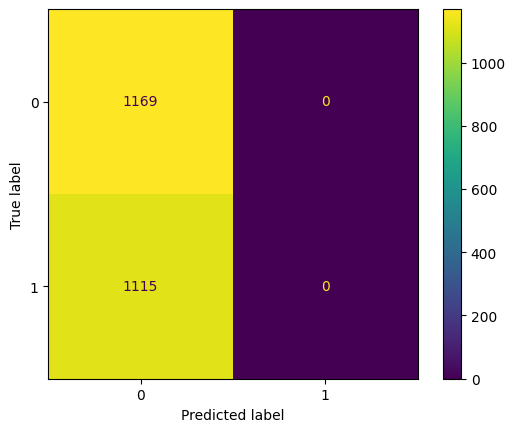

In [41]:
labels_ = m2_pipeline['label'].unique()
print(labels_)
vc.fit(X_train_scaled, y_train)

y_pred_vc = vc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_vc, labels=labels_)

print(classification_report(y_test, y_pred_vc,zero_division=1))

## voting classifier classifier report (error reporting part 2)

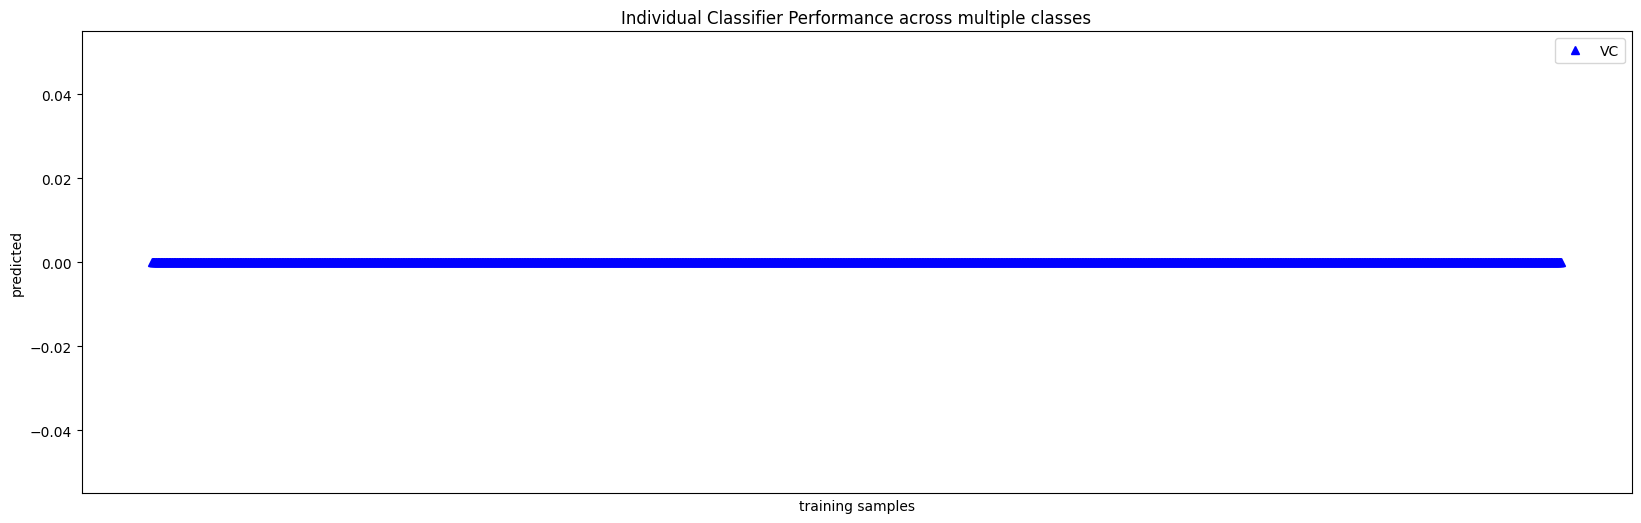

In [43]:
plt.figure(figsize=(20,6))
plt.plot(y_pred_vc, "b^", label="VC")

# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
plt.show()

### understand the high output classifiers inside the voting classifier

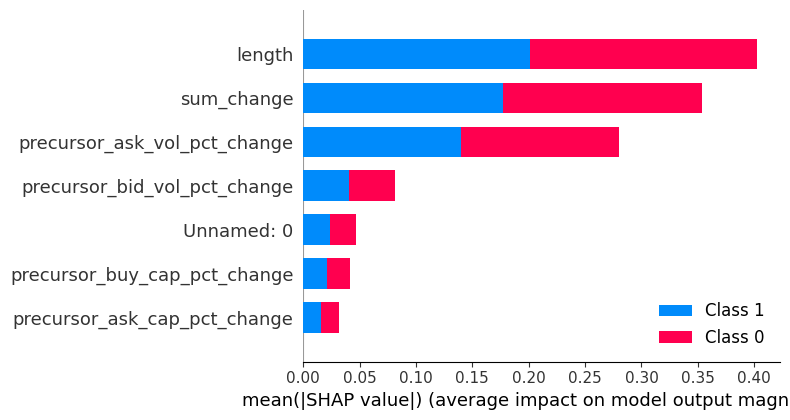

In [45]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = brf.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

## binary classifier error reporting

In [28]:
print_dict = lambda x: print(x)

# Apply the lambda function to each row of the data frame
optimals.applymap(print_dict)

LogisticRegression
BernoulliNB
KNeighborsClassifier
{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42}
{'fit_prior': True}
{'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 3}
0.5128989943156974
0.4958460865763008
0.5128989943156974


DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,classifier,best_params,accuracy
0,None,None,None
1,None,None,None
2,None,None,None


### logistic regression fit, predict and error reporting

0.5128989943156974
[0 1]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      1173
           1       1.00      0.00      0.00      1114

    accuracy                           0.51      2287
   macro avg       0.76      0.50      0.34      2287
weighted avg       0.75      0.51      0.35      2287



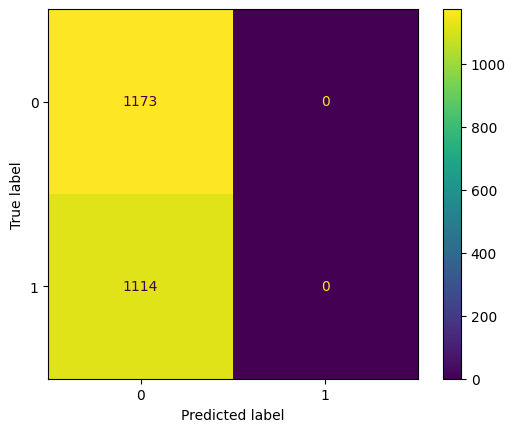

In [29]:
logreg = LogisticRegression(C=0.1, multi_class='ovr', penalty='l2', random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(accuracy_lr)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, labels=labels_)

print(classification_report(y_test, y_pred_lr,zero_division=1))

### Naive Bayes (Bernouilli) classifier accuracy and error report

0.4958460865763008
[0 1]
              precision    recall  f1-score   support

           0       0.81      0.02      0.04      1173
           1       0.49      0.99      0.66      1114

    accuracy                           0.50      2287
   macro avg       0.65      0.51      0.35      2287
weighted avg       0.66      0.50      0.34      2287



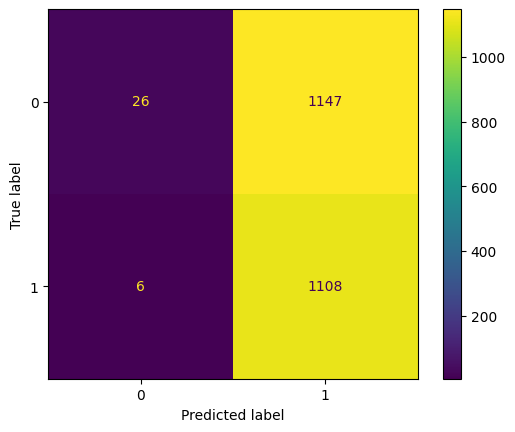

In [30]:
bnb = BernoulliNB(fit_prior=True)
bnb.fit(X_train_scaled, y_train)

y_pred_nb = bnb.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(accuracy_nb)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, labels=labels_)

print(classification_report(y_test, y_pred_nb,zero_division=1))

### KN Neighbors Classifier error and classification report

0.5128989943156974
[0 1]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      1173
           1       1.00      0.00      0.00      1114

    accuracy                           0.51      2287
   macro avg       0.76      0.50      0.34      2287
weighted avg       0.75      0.51      0.35      2287



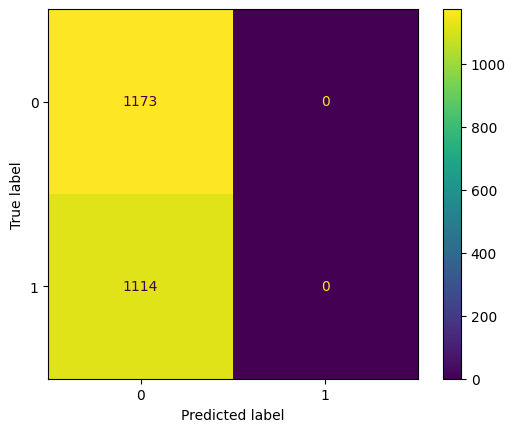

In [31]:
knn = KNeighborsClassifier(algorithm='auto', n_jobs=1, n_neighbors=6)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(accuracy_knn)

labels_ = m2_pipeline['label'].unique()
print(labels_)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, labels=labels_)

print(classification_report(y_test, y_pred_knn ,zero_division=1))